In [1]:
# External dependencies
import numpy as np
import pandas as pd
import yfinance as yf
from matplotlib import pyplot as plt

In [ ]:
def time_series_z_score(data: pd.DataFrame, statistic: str, halflife: int) -> pd.Series:
    return (
        (data[statistic] - data[statistic].ewm(halflife=halflife, min_periods=2*halflife).mean())
        / data[statistic].ewm(halflife=halflife, min_periods=2*halflife).std()
    ).dropna()


def get_week_of_month(date: pd.Timestamp) -> int:
    """
    Calculates the numerical (not calendar) week of the month.
    """
    return int(np.ceil(date.day / 7))


def plot_by_time_of_month(data: pd.DataFrame, statistic: str, title: str, groupby: str = "day_of_month", kind: str = "line") -> None:

    pd.DataFrame(
        {
            "50%": data.groupby(groupby)[statistic].median(),
            "90%": data.groupby(groupby)[statistic].quantile(q=0.90),
            "10%": data.groupby(groupby)[statistic].quantile(q=0.10),
        }
    ).plot(kind=kind, title=title, legend=True)
    plt.show()

    return

In [3]:
spy = yf.download(tickers="SPY", period="max")

[*********************100%***********************]  1 of 1 completed


<Axes: title={'center': 'Standardized Volume'}, xlabel='Date'>

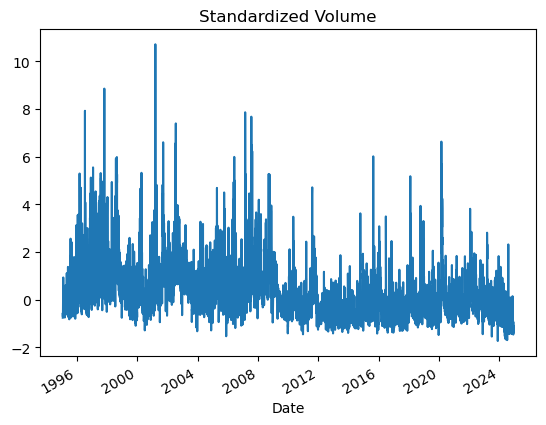

In [4]:
spy["standardized_volume"] = time_series_z_score(data=spy, statistic="Volume", halflife=252)
spy["standardized_volume"].plot(title="Standardized Volume")

In [5]:
spy["day_of_month"] = [date.day for date in spy.index]
spy["week_of_month"] = [get_week_of_month(date=date) for date in spy.index]

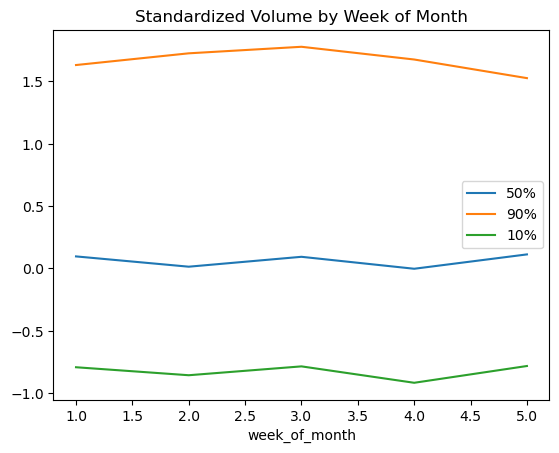

In [6]:
plot_by_time_of_month(data=spy, statistic="standardized_volume", title="Standardized Volume by Week of Month", groupby="week_of_month", kind="line")

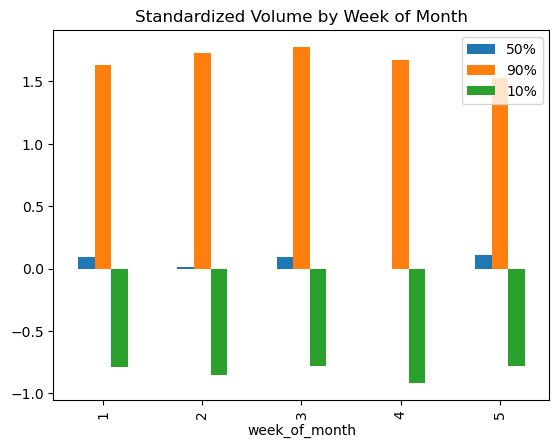

In [7]:
plot_by_time_of_month(data=spy, statistic="standardized_volume", title="Standardized Volume by Week of Month", groupby="week_of_month", kind="bar")

In [8]:
spy["close_returns"] = spy["Close"].pct_change()
spy["standardized_close_returns"] = time_series_z_score(data=spy, statistic="close_returns", halflife=252)
spy["standardized_close_returns"]

Date
1993-01-29 00:00:00+00:00         NaN
1993-02-01 00:00:00+00:00         NaN
1993-02-02 00:00:00+00:00         NaN
1993-02-03 00:00:00+00:00         NaN
1993-02-04 00:00:00+00:00         NaN
                               ...   
2024-12-09 00:00:00+00:00   -0.603268
2024-12-10 00:00:00+00:00   -0.394658
2024-12-11 00:00:00+00:00    0.709984
2024-12-12 00:00:00+00:00   -0.604412
2024-12-13 00:00:00+00:00   -0.097968
Name: standardized_close_returns, Length: 8027, dtype: float64

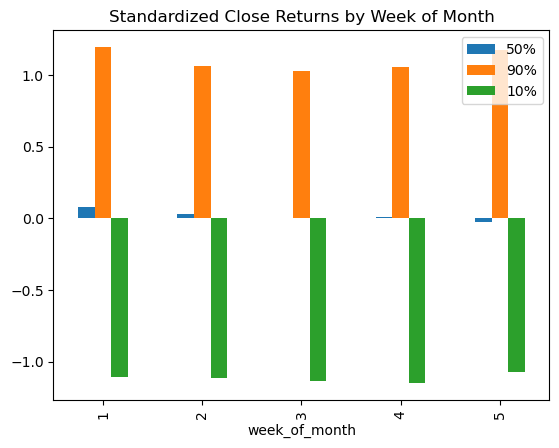

In [9]:
plot_by_time_of_month(data=spy, statistic="standardized_close_returns", title="Standardized Close Returns by Week of Month", groupby="week_of_month", kind="bar")

Perhaps market agents are less risk averse at the beginning of the month, and more so toward the end of the month.

This could be risk-on vs. risk-off market dislocaton.

<Axes: xlabel='week_of_month'>

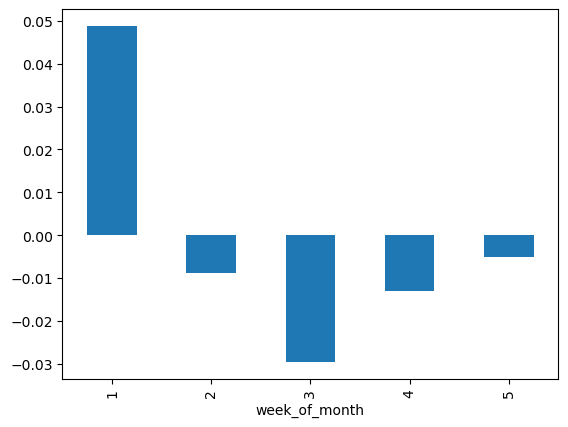

In [10]:
spy.groupby("week_of_month")["standardized_close_returns"].mean().plot(kind="bar")

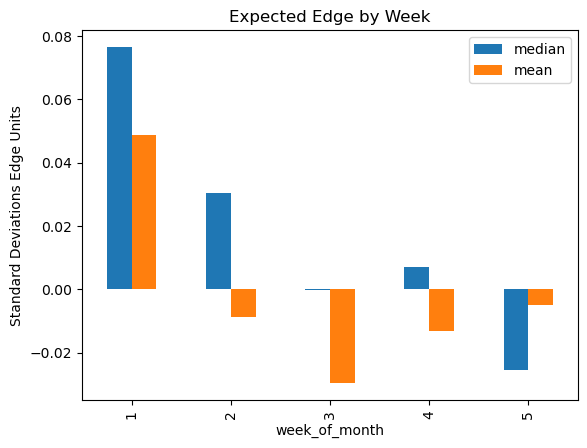

In [11]:
pd.DataFrame(
    {
        "median": spy.groupby("week_of_month")["standardized_close_returns"].median(),
        "mean": spy.groupby("week_of_month")["standardized_close_returns"].mean()
    }
).plot(kind="bar")


plt.title("Expected Edge by Week")
plt.ylabel("Standard Deviations Edge Units")
plt.legend()
plt.show()

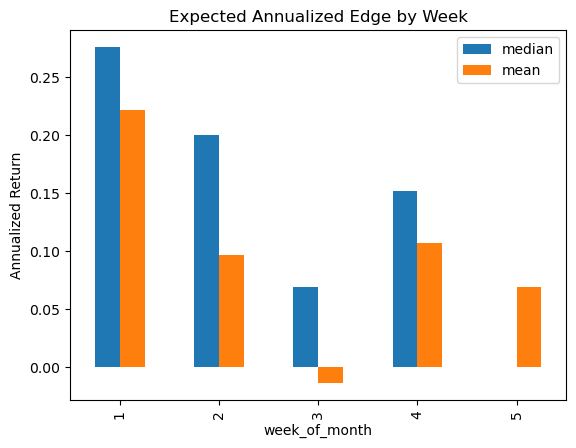

In [12]:
pd.DataFrame(
    {
        "median": spy.groupby("week_of_month")["close_returns"].median() * 252,
        "mean": spy.groupby("week_of_month")["close_returns"].mean() * 252
    }
).plot(kind="bar")


plt.title("Expected Annualized Edge by Week")
plt.ylabel("Annualized Return")
plt.legend()
plt.show()

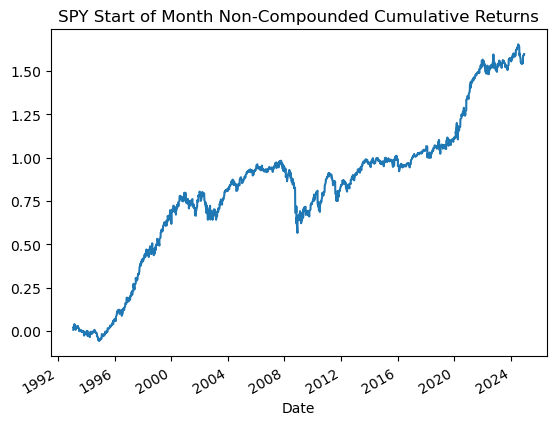

1.19156243027553


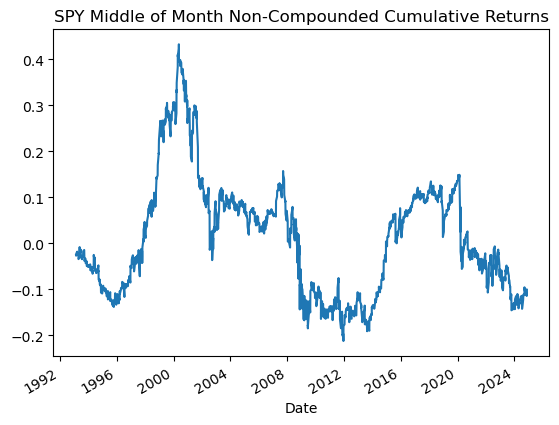

-0.07386269353333222


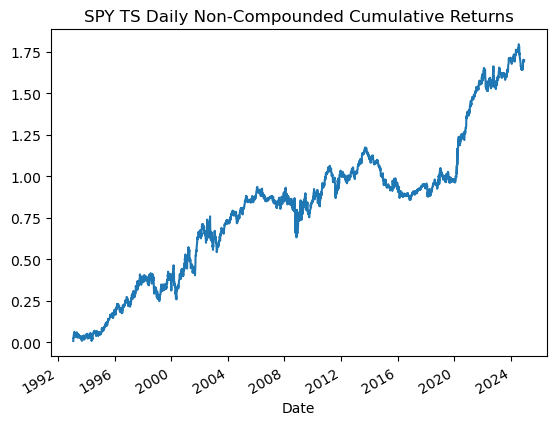

0.6277669629348687


In [13]:
spy_start_of_month_daily_returns = spy[spy["week_of_month"] == 1]["close_returns"].dropna()
spy_start_of_month_daily_returns.cumsum().plot(title="SPY Start of Month Non-Compounded Cumulative Returns")
plt.show()
print(spy_start_of_month_daily_returns.mean() / spy_start_of_month_daily_returns.std() * np.sqrt(252))


spy_middle_of_month_daily_returns = spy[spy["week_of_month"] == 3]["close_returns"].dropna()
spy_middle_of_month_daily_returns.cumsum().plot(title="SPY Middle of Month Non-Compounded Cumulative Returns")
plt.show()
print(spy_middle_of_month_daily_returns.mean() / spy_middle_of_month_daily_returns.std() * np.sqrt(252))

spy_ts_daily_returns = pd.concat([spy_start_of_month_daily_returns, -spy_middle_of_month_daily_returns], axis=1).sum(axis=1)
spy_ts_daily_returns.cumsum().plot(title="SPY TS Daily Non-Compounded Cumulative Returns")
plt.show()
print(spy_ts_daily_returns.mean() / spy_ts_daily_returns.std() * np.sqrt(252))

In [14]:
spy["close_returns"].mean() / spy["close_returns"].std() * np.sqrt(252)

0.5347617010817638

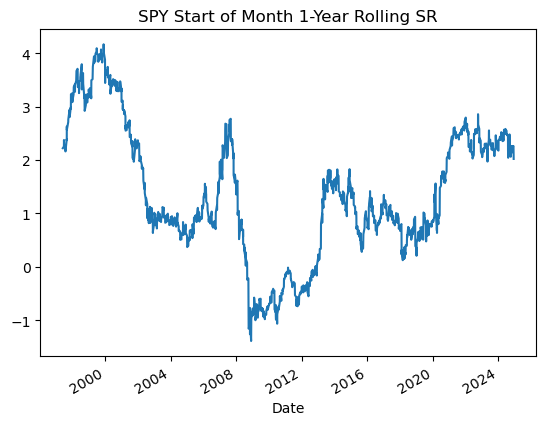

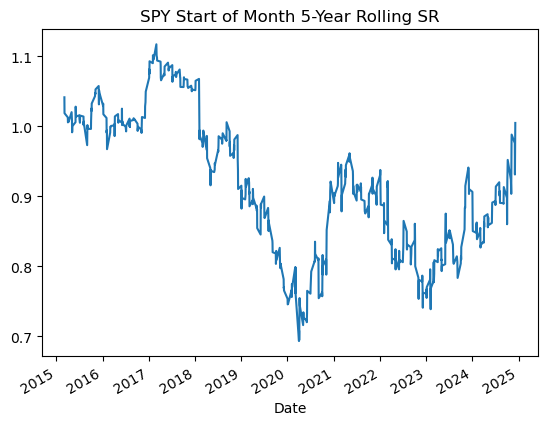

In [15]:
(spy_start_of_month_daily_returns.rolling(252).mean() / spy_start_of_month_daily_returns.rolling(252).std() * np.sqrt(252)).plot(title="SPY Start of Month 1-Year Rolling SR")
plt.show()

(spy_start_of_month_daily_returns.rolling(5 * 252).mean() / spy_start_of_month_daily_returns.rolling(5 * 252).std() * np.sqrt(252)).plot(title="SPY Start of Month 5-Year Rolling SR")
plt.show()